In [54]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# News data analysis

In [55]:
news = pd.read_csv('dutch-news-articles.csv')
news.head(2)

,datetime,title,content,category,url
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...


## Data preprocessing

In [56]:
# convert date for better usage
news['datetime'] = pd.to_datetime(news['datetime'])
news['date'] = pd.to_datetime(news['datetime'].dt.date)
news['year'] = news['datetime'].apply(lambda x: x.strftime('%Y')) 
news['year'] = news['year'].astype('int')
news['week_number'] = news['date'].dt.isocalendar().week

In [57]:
# change order of df colums for better interpretation
first_column = news.pop('date')
second_column = news.pop('year')
third_column = news.pop('week_number')

news.insert(0, 'date', first_column)
news.insert(1, 'year', second_column)
news.insert(2, 'week_number', third_column)
news = news.drop(['datetime'], axis=1)

In [58]:
# lowercase content column and replace some letters
news['content'] = news['content'].apply(lambda x: x.lower())
news['content'] = news.content.str.replace('ï','i')

In [59]:
news.tail(2)

,date,year,week_number,title,content,category,url
246455,2022-12-04,2022,48,Vulkaan op Java barst uit: rookpluim van 15 ki...,indonesische autoriteiten hebben de alarmfase ...,Buitenland,https://nos.nl//artikel/2455058-vulkaan-op-jav...
246456,2022-12-04,2022,48,Iran executeert vier mannen om werk voor inlic...,iran heeft vier mannen geëxecuteerd die ervan...,Buitenland,https://nos.nl//artikel/2455070-iran-executeer...


## Data augmentation

In [60]:
regional_labels = ['l1mburg', 
                   'nh nieuws', 
                   'omroep brabant', 
                   'omrop frylân', 
                   'omroep gelderland', 
                   'omroep west',
                   'omroep zeeland',
                   'rijnmond',
                   'rtv rijnmond',
                   'rtv drenthe',
                   'rtv noord',
                   'rtv oost',
                   'rtv utrecht'
                  ]

def contains_omroep(text):
    return [omroep for omroep in regional_labels if omroep in text]

drug_labels = ['cocaine',
                   'ghb',
                   'xtc'
                  ]

def contains_drug(text):
    return [drug for drug in drug_labels if drug in text]

In [61]:
# create 'omroep' and 'drugs' columns
news['omroep'] = news.content.apply(contains_omroep)
news['drugs'] = news.content.apply(contains_drug)

# add seperate columns for each drug
searchfor_cocaine = ['cocaine', 'cocaïne', 'Cocaine', 'Cocaïne']
searchfor_GHB = ['ghb', 'GHB']
searchfor_XTC = ['xtc', 'XTC']


news['cocaine'] = news.content.str.contains('cocaine')
news['ghb'] = news.content.str.contains('ghb')
news['xtc'] = news.content.str.contains('xtc')

## Data inspection

In [74]:
news[news.omroep.apply(len)>0].head(1)

,date,year,week_number,title,content,category,url,omroep,drugs,cocaine,ghb,xtc
312,2010-01-11,2010,2,Meijboom stelt verbeteringen voor,de rotterdamse korpschef meijboom heeft burgem...,Binnenland,https://nos.nl/artikel/128434-meijboom-stelt-v...,[rijnmond],[],False,False,False


In [75]:
news[news.drugs.apply(len)>0].head(1)

,date,year,week_number,title,content,category,url,omroep,drugs,cocaine,ghb,xtc
125,2010-01-05,2010,1,1100 kilo cocaïne gevonden tussen de whisky,politie en douane hebben in rotterdam 1100 kil...,Binnenland,https://nos.nl/artikel/127048-1100-kilo-cocain...,[],[cocaine],True,False,False


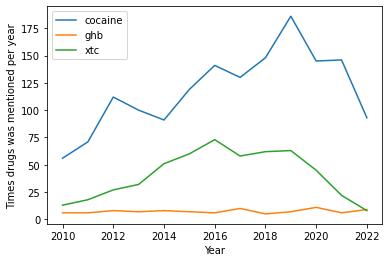

In [73]:
cocaine = news[news['cocaine'] == True].groupby(['year'])['cocaine'].count()
ghb = news[news['ghb'] == True].groupby(['year'])['ghb'].count()
xtc = news[news['xtc'] == True].groupby(['year'])['xtc'].count()

plt.plot(cocaine.index, cocaine.values, label='cocaine')
plt.plot(ghb.index, ghb.values, label='ghb')
plt.plot(xtc.index, xtc.values, label='xtc')
plt.xlabel('Year')
plt.ylabel('Times drugs was mentioned per year')
plt.legend()
plt.show()


## Create data subsets for dashboard

### compute absolute scores for drug articles per week per drug

In [67]:
cocaine_absolute = news[news['cocaine'] == True].groupby(['year', 'week_number'])['content'].count()
xtc_absolute = news[news['xtc'] == True].groupby(['year', 'week_number'])['content'].count()
ghb_absolute = news[news['xtc'] == True].groupby(['year', 'week_number'])['content'].count()

### Compute relative scores for drug articles per week per drug

#### Cocaine

In [83]:
# apply grouping
average_per_week = news.groupby(['year'])['week_number'].count() / 52
articles_per_week = news[news['cocaine'] == True].groupby(['year', 'week_number'])['content'].count()
max_articles_per_year = articles_per_week.groupby(level=0).apply(max)
min_articles_per_year = articles_per_week.groupby(level=0).apply(min)

# make relative
relative_articles_per_week = articles_per_week / average_per_week
max_articles_per_year = relative_articles_per_week.groupby(level=0).apply(max)

# normalize
cocaine_relative = relative_articles_per_week / max_articles_per_year * 100

#### XTC

In [84]:
# apply grouping
average_per_week = news.groupby(['year'])['week_number'].count() / 52
articles_per_week = news[news['xtc'] == True].groupby(['year', 'week_number'])['content'].count()
max_articles_per_year = articles_per_week.groupby(level=0).apply(max)
min_articles_per_year = articles_per_week.groupby(level=0).apply(min)

# make relative
relative_articles_per_week = articles_per_week / average_per_week
max_articles_per_year = relative_articles_per_week.groupby(level=0).apply(max)

# normalize
xtc_relative = relative_articles_per_week / max_articles_per_year * 100

#### GHB

In [85]:
# apply grouping
average_per_week = news.groupby(['year'])['week_number'].count() / 52
articles_per_week = news[news['ghb'] == True].groupby(['year', 'week_number'])['content'].count()
max_articles_per_year = articles_per_week.groupby(level=0).apply(max)
min_articles_per_year = articles_per_week.groupby(level=0).apply(min)

# make relative
relative_articles_per_week = articles_per_week / average_per_week
max_articles_per_year = relative_articles_per_week.groupby(level=0).apply(max)

# normalize
ghb_relative = relative_articles_per_week / max_articles_per_year * 100

## Save subsets as files

#### Save absolute files

In [87]:
cocaine_absolute.to_csv("datasets/absolute_news_acticles_cocaine.csv")
xtc_absolute.to_csv("datasets/absolute_news_acticles_xtc.csv")
ghb_absolute.to_csv("datasets/absolute_news_acticles_ghb.csv")

#### Save absolute files

In [88]:
cocaine_relative.to_csv("datasets/relative_news_acticles_cocaine.csv")
xtc_relative.to_csv("datasets/relative_news_acticles_xtc.csv")
ghb_relative.to_csv("datasets/relative_news_acticles_ghb.csv")


#### Save dataset corpus

In [89]:
news.to_csv("datasets/_news_corpus.csv")